In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from math import log
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from functools import partial
from tqdm import tqdm
from multiprocessing import Pool
import pickle

In [2]:
def parallelize(func, groups):
    num_workers = 16
    with Pool(num_workers) as p:
        return pd.concat(p.map(func, [group for name, group in groups])).sort_index()

In [3]:
df = pd.read_pickle('../data/watch_list_clean.pkl.xz')[['title', 'username', 'rating']]

In [4]:
df

,title,username,rating
0,Day Break Illusion: il sole penetra le illusioni,Ruth,3.0
1,Dog Days,Ruth,3.5
2,Dog Days',Ruth,3.0
3,Fantasista Doll,Ruth,2.5
4,Fate/Kaleid Liner Prisma Illya,Ruth,3.5
...,...,...,...
9205777,The Ancient Magus' Bride,Rutendo,5.0
9205778,The Disastrous Life of Saiki K.,Rutendo,5.0
9205779,The Seven Deadly Sins,Rutendo,5.0
9205780,The Seven Deadly Sins: Revival of The Commandm...,Rutendo,5.0


## Scale user ratings to their own rating behavior

### Remove Outliers ($\pm3\sigma$)

def in_three_std(x):
    return x.between(x.quantile(0.05), x.quantile(0.95)) == 1

in_three_std_mask = parallelize(df.groupby('username')['user_rating'], in_three_std)

df.loc[~in_three_std_mask]

df = df.loc[in_three_std_mask].copy(deep=True)

### Standard Scaling by User (Mean/Std Scaler)

In [5]:
def group_rating_normalizer(group, scaler, value_col):
    scaled = scaler.fit_transform(group[[value_col]])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=group.index)

In [6]:
user_rating_normalizer = partial(group_rating_normalizer, scaler=StandardScaler(), value_col='rating')
df['orig_rating'] = df['rating']
df['rating'] = parallelize(user_rating_normalizer, df.groupby('username'))

In [7]:
df['rating'].agg(['min', 'max'])

min   -27.748874
max    10.440307
Name: rating, dtype: float64

(-5.0, 5.0)

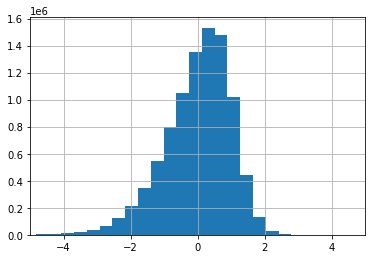

In [8]:
df['rating'].hist(bins=100)
plt.xlim(-5, 5)

### Scale ratings back to 0-5 scale with Logistic (Sigmoid) Curve

$$f(x) = \frac{1}{1+e^{-x}}$$

In [9]:
def sigmoid(x, scale=1):
    z = np.exp(-scale * x)
    return 1 / (1 + z)

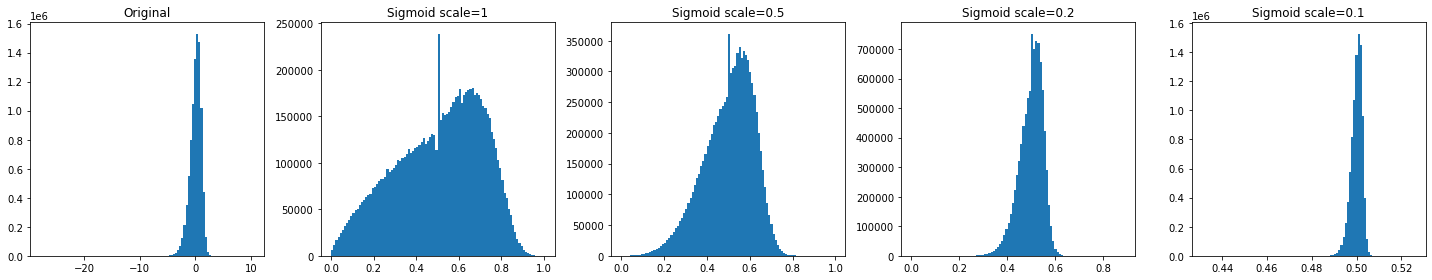

In [10]:
fig, axs = plt.subplots(1, 5, tight_layout=True, figsize=(20, 4))

axs[0].hist(df['rating'], bins=100)
axs[0].set_title('Original')

axs[1].hist(sigmoid(df['rating'], scale=1), bins=100)
axs[1].set_title('Sigmoid scale=1')

axs[2].hist(sigmoid(df['rating'], scale=0.5), bins=100)
axs[2].set_title('Sigmoid scale=0.5')

axs[3].hist(sigmoid(df['rating'], scale=0.2), bins=100)
axs[3].set_title('Sigmoid scale=0.2')

axs[4].hist(sigmoid(df['rating'], scale=0.01), bins=100)
axs[4].set_title('Sigmoid scale=0.1')

plt.show()

In [11]:
df['rating'] = sigmoid(df['rating'])

In [12]:
df

,title,username,rating,orig_rating
0,Day Break Illusion: il sole penetra le illusioni,Ruth,0.349558,3.0
1,Dog Days,Ruth,0.481646,3.5
2,Dog Days',Ruth,0.349558,3.0
3,Fantasista Doll,Ruth,0.237124,2.5
4,Fate/Kaleid Liner Prisma Illya,Ruth,0.481646,3.5
...,...,...,...,...
9205777,The Ancient Magus' Bride,Rutendo,0.683313,5.0
9205778,The Disastrous Life of Saiki K.,Rutendo,0.683313,5.0
9205779,The Seven Deadly Sins,Rutendo,0.683313,5.0
9205780,The Seven Deadly Sins: Revival of The Commandm...,Rutendo,0.683313,5.0


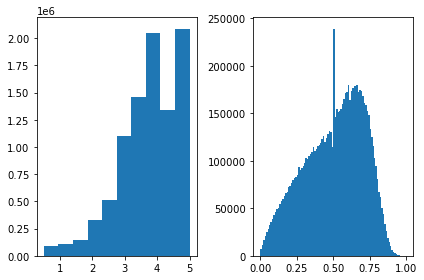

In [13]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(df['orig_rating'])
axs[1].hist(df['rating'], bins=100)
plt.show()

## Reshape

In [14]:
pivot = df.pivot(index='username', columns='title', values='rating')
pivot = pivot.sample(pivot.shape[0])

In [15]:
pivot.shape

(117162, 4489)

## Train-Validate-Test Split
- Train: 60%
- Validate: 20%
- Test: 20%

In [16]:
train = pivot.sample(frac=0.6, random_state=42)
pivot = pivot.drop(train.index)
validate = pivot.sample(frac=0.5, random_state=42)
test = pivot.drop(validate.index)

In [17]:
train.shape

(70297, 4489)

In [18]:
keeper_mask = np.random.choice(a=[True, False], size=train.shape, p=[0.75, 0.25])

In [19]:
train_X = train.mask(keeper_mask)
train_Y = train.mask(~keeper_mask)

validate_X = validate.mask(keeper_mask[:validate.shape[0]])
validate_Y = validate.mask(~keeper_mask[:validate.shape[0]])

test_X = test.mask(keeper_mask[:test.shape[0]])
test_Y = test.mask(~keeper_mask[:test.shape[0]])

## Saving Data

In [20]:
train_X.to_pickle('../data/train_X.pkl')
train_Y.to_pickle('../data/train_Y.pkl')
train.to_pickle('../data/train.pkl')

validate_X.to_pickle('../data/validate_X.pkl')
validate_Y.to_pickle('../data/validate_Y.pkl')
validate.to_pickle('../data/validate.pkl')

test_X.to_pickle('../data/test_X.pkl')
test_Y.to_pickle('../data/test_Y.pkl')
test.to_pickle('../data/test.pkl')

In [21]:
%%bash
cd ../data

xz -vfT14 train_X.pkl
xz -vfT14 train_Y.pkl
xz -vfT14 train.pkl

xz -vfT14 validate_X.pkl
xz -vfT14 validate_Y.pkl
xz -vfT14 validate.pkl

xz -vfT14 test_X.pkl
xz -vfT14 test_Y.pkl
xz -vfT14 test.pkl

train_X.pkl: 7,698.6 KiB / 2,409.3 MiB = 0.003, 311 MiB/s, 0:07
train_Y.pkl: 14.2 MiB / 2,409.3 MiB = 0.006, 281 MiB/s, 0:08
train.pkl: 16.6 MiB / 2,409.3 MiB = 0.007, 282 MiB/s, 0:08
validate_X.pkl: 2,960.0 KiB / 804.1 MiB = 0.004, 0:02
validate_Y.pkl: 5,221.4 KiB / 804.1 MiB = 0.006, 249 MiB/s, 0:03
validate.pkl: 6,050.8 KiB / 804.1 MiB = 0.007, 239 MiB/s, 0:03
test_X.pkl: 2,978.1 KiB / 804.1 MiB = 0.004, 0:02
test_Y.pkl: 5,248.4 KiB / 804.1 MiB = 0.006, 257 MiB/s, 0:03
test.pkl: 6,080.1 KiB / 804.1 MiB = 0.007, 241 MiB/s, 0:03


In [22]:
train.to_csv('../data/train.csv')
validate.to_csv('../data/validate.csv')
test.to_csv('../data/test.csv')

In [23]:
%%bash
cd ../data

xz -vfT14 train.csv
xz -vfT14 validate.csv
xz -vfT14 test.csv

train.csv: 14.6 MiB / 396.2 MiB = 0.037, 42 MiB/s, 0:09
validate.csv: 4,988.7 KiB / 132.0 MiB = 0.037, 34 MiB/s, 0:03
test.csv: 5,020.3 KiB / 132.5 MiB = 0.037, 34 MiB/s, 0:03
